In [1]:
from dask.distributed import Client
import multiprocessing
ncpu = multiprocessing.cpu_count()
threads = 8
nworker = ncpu//threads
print(ncpu, threads, nworker)

client = Client(processes=False, threads_per_worker=threads,
                n_workers=nworker, memory_limit='64GB')
client

48 8 6


<Client: 'inproc://10.50.40.248/26340/1' processes=6 threads=48, memory=384.00 GB>

In [1]:
from dask.distributed import Client

client = Client("tcp://10.50.40.248:43511")
client

<Client: 'tcp://10.50.40.248:43511' processes=0 threads=0, memory=0 B>

In [9]:
# dask jobqueue
# 4 nodes: 24 workers, 192 cores, 256 GB memory

In [28]:
import pymistral
import intake
import dask
import matplotlib.pyplot as plt
import xarray as xr

In [44]:
cat = intake.open_catalog('/home/mpim/m300524/pymistral/intake/obs.yml')

In [45]:
ds = cat['MODIS'].to_dask()#(chunks={'lon':'auto','lat':'auto'}).to_dask()

In [46]:
dask.utils.format_bytes(ds.nbytes)

'313.53 GB'

In [47]:
dask.utils.format_bytes(ds.chla.nbytes)

'31.35 GB'

In [48]:
dask.utils.format_bytes(ds.isel(time=-1).chla.nbytes)

'149.30 MB'

In [49]:
ds['time']=xr.cftime_range(start='2002-07',freq='MS',periods=ds.time.size,calendar='360_day')

In [50]:
ds=ds.sel(time=slice('2003','2019'))

In [51]:
ds.chla.data

dask.array<getitem, shape=(204, 4320, 8640), dtype=float32, chunksize=(1, 4320, 8640), chunktype=numpy.ndarray>

In [52]:
dsc = ds.chla#.isel(lon=slice(0,500),lat=slice(2000,3000))

In [60]:
fig,ax=plt.subplots(figsize=(15,7))
dsc.isel(time=0).plot_map(feature='land')

In [51]:
#dsc = dsc.fillna(0.)

In [50]:
dscs = dsc.sum(['lon','lat']).dropna('time')
display(dscs.data)
%time dscs = dscs.compute()

dask.array<sum-aggregate, shape=(210,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>

CPU times: user 1min 31s, sys: 1min 42s, total: 3min 14s
Wall time: 36.9 s


In [67]:
#pymistral.plot.CartopyMap??

In [51]:
dscs.plot()

# big data analysis
- remove seasonal cycle
- variance weighted mean period

In [63]:
dscrms = dsc.groupby('time.month') - dsc.groupby('time.month').mean()

In [64]:
del dscrms['month']

In [16]:
dscs2 = dscrms.sum(['lon','lat'])
display(dscs2.data)
%time dscs2 = dscs2.compute()

dask.array<sum-aggregate, shape=(210,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>

CPU times: user 4min 38s, sys: 16min 17s, total: 20min 56s
Wall time: 1min 36s


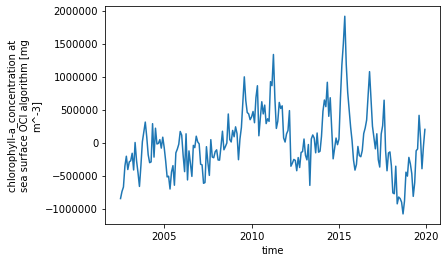

In [31]:
dscs2.plot()

In [55]:
dscrms['time']=range(dscrms.time.size)

In [65]:
dscrms=dscrms.chunk({'time':-1,'lon':'auto','lat':'auto'})
dscrms.data

dask.array<rechunk-merge, shape=(204, 4320, 8640), dtype=float32, chunksize=(204, 270, 540), chunktype=numpy.ndarray>

In [24]:
import climpred

In [25]:
vwmp = climpred.stats.varweighted_mean_period(dscrms)
vwmp.data

dask.array<truediv, shape=(4320, 8640), dtype=float64, chunksize=(270, 540), chunktype=numpy.ndarray>

In [26]:
%time vwmp = vwmp.compute()

CPU times: user 5.7 s, sys: 344 ms, total: 6.04 s
Wall time: 1min 19s


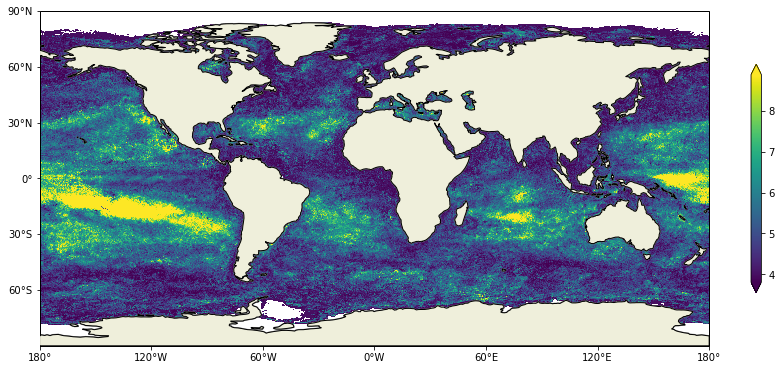

In [29]:
fig,ax=plt.subplots(figsize=(15,7))
vwmp.plot_map(feature='land')

# ENSO composite

In [57]:
import pandas as pd

In [58]:
def NINO3(reference_period_start=1960, reference_period_end=1989, month=None):
    nino3 = pd.read_csv('~/nina3.data', sep='  ', skiprows=3, skipfooter=4,
                        names=['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], index_col=['Year'])
    ds_nino3 = xr.DataArray(nino3.values.flatten(), coords=[pd.date_range(
        start='1950', freq='M', periods=nino3.size)], dims='time')
    if reference_period_start is None and reference_period_end is None:
        return ds_nino3
    elif isinstance(reference_period_start, int) and isinstance(reference_period_end, int):
        if isinstance(month, int):
            clim = ds_nino3.sel(time=ds_nino3.time.dt.month == month).sel(time=slice(
                str(reference_period_start), str(reference_period_end)))
        else:
            clim = ds_nino3.sel(time=slice(
                str(reference_period_start), str(reference_period_end))).groupby('time.month')
        # standardize
        if isinstance(month, int):
            std = ((ds_nino3.sel(time=ds_nino3.time.dt.month ==
                                 month) - clim.mean('time')) / (clim.std('time')))
        else:
            std = ((ds_nino3.groupby('time.month') -
                    clim.mean('time')).groupby('time.month') / (clim.std('time')))
        std.name = 'NINO3'
        return std

In [59]:
enso = NINO3(reference_period_start=2000, reference_period_end=2019).sel(time=slice('2003','2019'))

In [60]:
enso-=enso.mean('time')

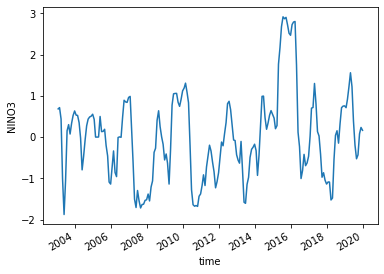

In [61]:
enso.plot()

In [66]:
dscrms = dscrms.sel(time=slice('2003','2019')).chunk({'time':12,'lon':'auto','lat':'auto'})
dscrms.data

dask.array<rechunk-merge, shape=(204, 4320, 8640), dtype=float32, chunksize=(12, 1080, 2160), chunktype=numpy.ndarray>

In [67]:
import esmtools as et

In [ ]:
comp = et.composite.composite_analysis(dsc,enso, threshold=.75)

In [69]:
comp.data

dask.array<getitem, shape=(2, 4320, 8640), dtype=float32, chunksize=(1, 4320, 8640), chunktype=numpy.ndarray>

In [70]:
%time comp=comp.compute()

CPU times: user 608 ms, sys: 633 ms, total: 1.24 s
Wall time: 39.1 s


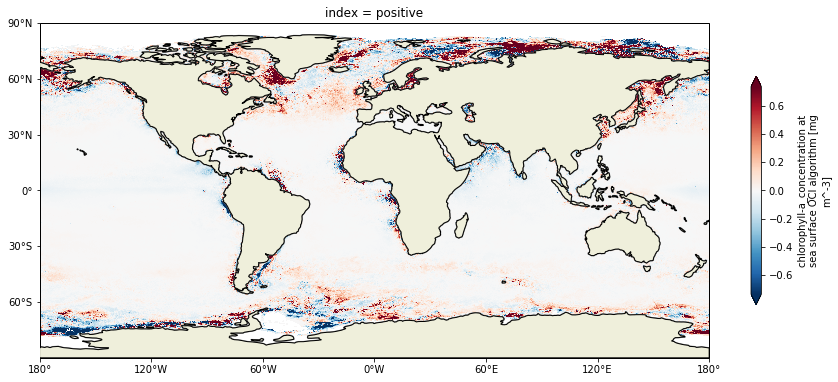

In [71]:
fig,ax=plt.subplots(figsize=(15,7))
comp.isel(index=0).plot_map(feature='land')

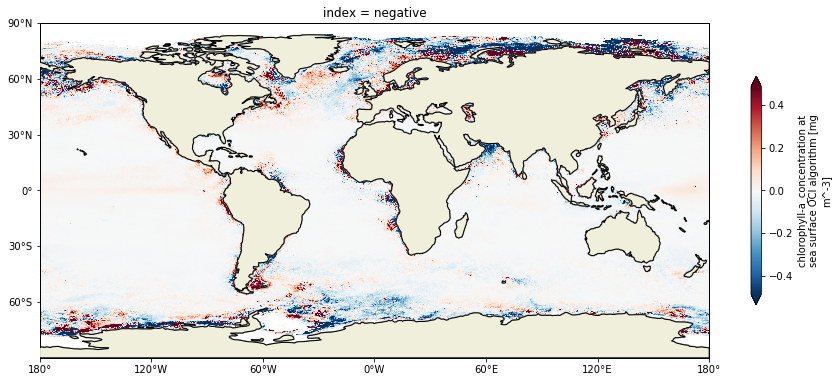

In [72]:
fig,ax=plt.subplots(figsize=(15,7))
comp.isel(index=1).plot_map(feature='land')